# Generate Particle ID
This notebook is used to select a particle group (particle ID) from the estimates generated by the estimate phase of Spyral. If you haven't already run the estimate phase and try to use this notebook, it will fail. For more information on what a particle ID is and how it is used see [this section](https://attpc.github.io/Spyral/user_guide/phases/estimate/#plotting-and-particle-id) of the Spyral documentation.

First lets import our modules:

In [1]:
from spyral_utils.plot import CutHandler, Histogrammer
from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.particle_id import serialize_particle_id, ParticleID
from spyral.core.constants import DEG2RAD
from spyral.core.run_stacks import form_run_string

import polars as pl
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from pathlib import Path

%matplotlib widget

RAD2DEG = 1.0/DEG2RAD

With our modules loaded we can now begin setting up our configuration

In [2]:
# Set some parameters
workspace_path = Path("/Volumes/researchEXT/O16/no_efield/no_field_fitracks_v1.0/")
estimation_result_path = workspace_path / "Estimation"

# Set the run range (inclusive)
run_min = 54
run_max = 54

# IC gate
ic_min_val = -10
ic_max_val = 4096.0

# Nucleus map
nuclear_map = NuclearDataMap()

Here we'll set some parameters we'll use for the particle ID. You'll want to change these for your specific particle ID. ***Make sure to modify this for your experiment!***

In [3]:
# Set these!
pid_name = "alpha_cut" # name given to PID
pid_z = 2 # atomic number
pid_a = 4 # mass number
nucleus = nuclear_map.get_data(pid_z, pid_a)
pid_x_axis = "sqrt_dEdx" # This is the PID x-axis, matching a column name in the estimation dataframe
pid_y_axis = "brho" # This is the PID y-axis, matching a column name in the estimation dataframe
pid_path = Path("/Users/pranjalsingh/Desktop/research_space_spyral/Spyral_1.0/particle_test.json") # Path to which we will write our PID


Now we'll create some utility objects from spyral-utils that will help us with the plotting

In [4]:
grammer = Histogrammer()
handler = CutHandler()

Now we'll add some histograms to the Histogrammer

In [5]:
grammer.add_hist2d("particle_id", (400, 400), ((-10.0, 200.0), (-0.1, 3.0))) # Plot of particle ID. Depending on your axes, you may need to change these limits, binning
grammer.add_hist1d("ion_chamber", 4096, (0.0, 4096.0)) # Plot of ion chamber (beam ID)
grammer.add_hist2d("kinematics", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics)

With our histograms created, we're now ready to load the data and fill the histograms!

In [6]:
for run in range(run_min, run_max+1):
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pl.scan_parquet(run_path)
    
    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    # Don't comment the line below!
    df = df.collect()

    grammer.fill_hist2d('particle_id', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy()) # Use your custom axes
    grammer.fill_hist2d('kinematics', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())
    grammer.fill_hist1d('ion_chamber', df.unique(subset=['event']).select('ic_amplitude').to_numpy())

With our data loaded and histograms filled, we are ready to plot! We'll use the plotly library to make some interactive histograms. First, the ion chamber

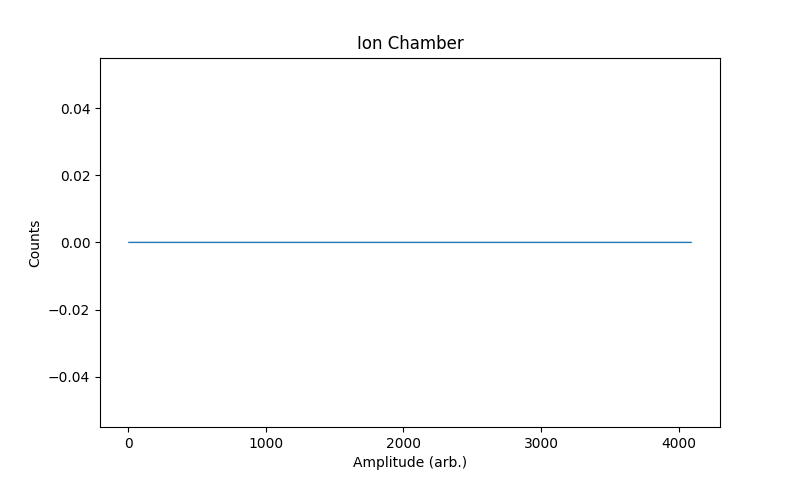

In [7]:
ic = grammer.get_hist1d("ion_chamber")
fig, ax = plt.subplots(1,1)
ax.stairs(ic.counts, edges=ic.bins)
ax.set_title("Ion Chamber")
ax.set_xlabel("Amplitude (arb.)")
ax.set_ylabel("Counts")
fig.set_figwidth(8.0)

You should see a plot of the ion chamber above!

Now lets plot the interesting bit, the particle ID. We also need to bind our cut handler to the figure we make, so the code below is a tad more involved.

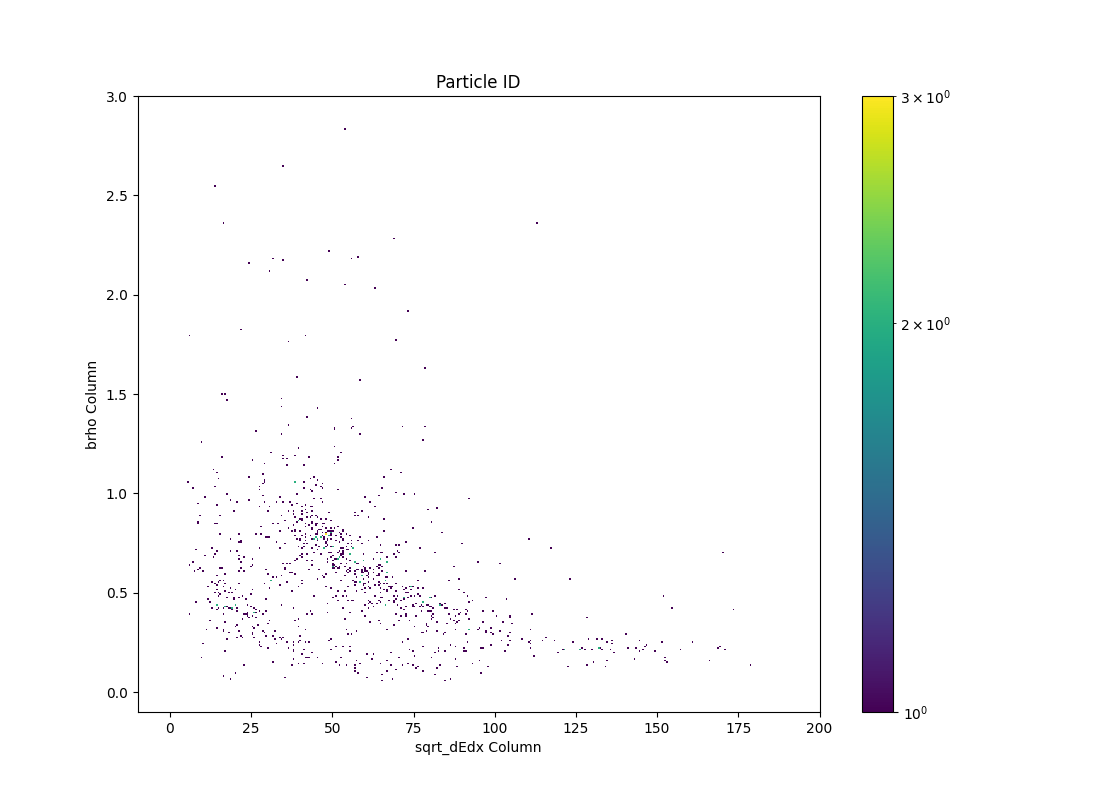

In [8]:
pid_hist = grammer.get_hist2d("particle_id")
fig, ax = plt.subplots(1,1)
_ = PolygonSelector(ax, handler.mpl_on_select)
mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts, norm="log")
fig.colorbar(mesh, ax=ax)
ax.set_title("Particle ID")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)


You should see the particle ID spectrum above! You can draw your cut by clicking the points to make the cut on the plot. Make sure to close the polygon by clicking the first point you made!

Lets also plot our kinematics

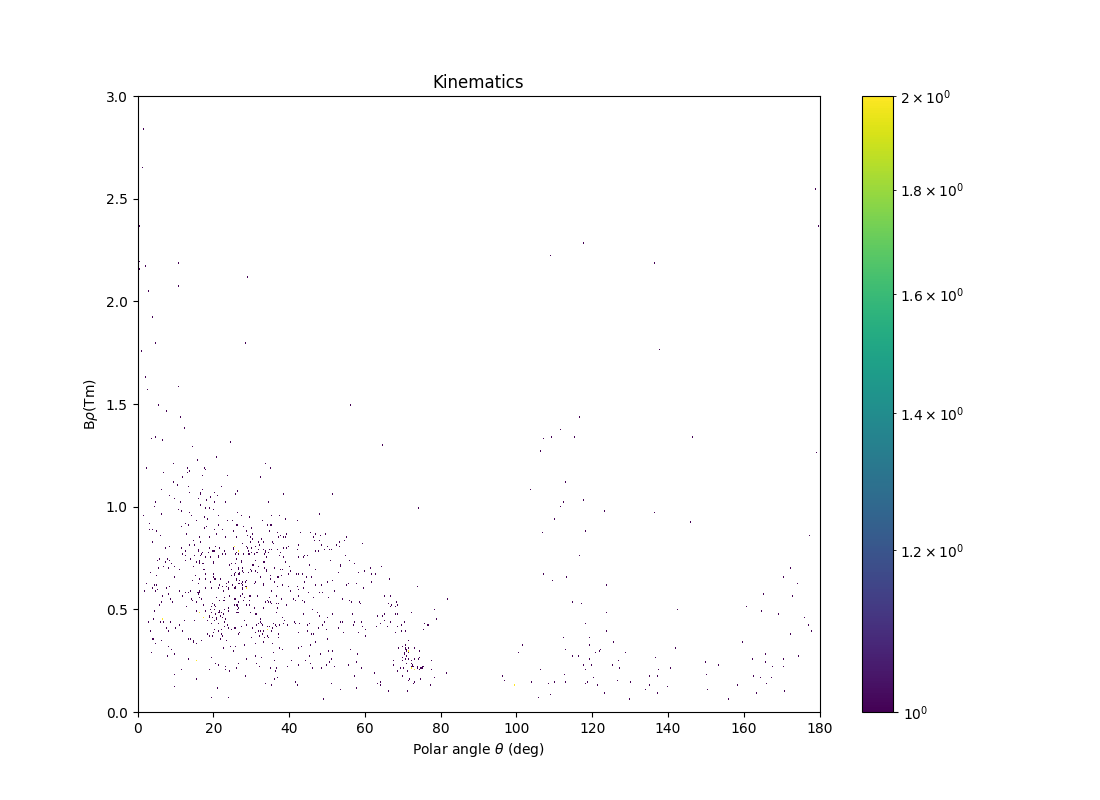

In [9]:
kine = grammer.get_hist2d("kinematics")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(kine.x_bins, kine.y_bins, kine.counts, norm="log")
fig.colorbar(mesh, ax=ax)
ax.set_title("Kinematics")
ax.set_xlabel("Polar angle $\\theta$ (deg)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

You should see a spectrum of the kinematics above!

Once you've done all of that and have *made* a selection in the particle ID, we want to save the particle ID to our workspace. Only run the cell below once you've made a selection!

In [10]:
# If you've made multiple cuts, you'll want to change the name used here. Cuts are automatically named in the order they were made (first cut is cut_0, second cut_1, etc.)
cut = handler.cuts["cut_0"]
cut.name = pid_name # give it our custom name
cut.x_axis = pid_x_axis # specify our axes
cut.y_axis = pid_y_axis
pid = ParticleID(cut, nucleus)
# Save our pid
serialize_particle_id(pid_path, pid)


KeyError: 'cut_0'

Great! Now if you look in the PID file, you should see some JSON describing the cut!

As a test, we can now load the particle ID and apply it to itself and our kinematics. This helps us make sure that everything is working correctly. Again, only run this cell if you've already saved a particle ID!

In [20]:
grammer.add_hist2d("particle_id_gated", (400, 400), ((-10.0, 200.0), (0.0, 3.0))) # Plot of dEdx vs. Brho (particle ID), gated on PID
grammer.add_hist2d("kinematics_gated", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics), gated on PID

for run in range(run_min, run_max+1):
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pl.scan_parquet(run_path)

    df = df.filter(pl.struct([pid_x_axis, pid_y_axis]).map_batches(pid.cut.is_cols_inside)) # apply PID
    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    # Don't comment the line below!
    df = df.collect()

    grammer.fill_hist2d('particle_id_gated', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy())
    grammer.fill_hist2d('kinematics_gated', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())

In [ ]:
pid_gated = grammer.get_hist2d("particle_id_gated")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(pid_gated.x_bins, pid_gated.y_bins, pid_gated.counts, norm="log")
fig.colorbar(mesh, ax=ax)
ax.set_title("Particle ID Gated")
ax.set_xlabel(f"{pid_x_axis} Column")
ax.set_ylabel(f"{pid_y_axis} Column")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [ ]:
kine_gated = grammer.get_hist2d("kinematics_gated")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(kine_gated.x_bins, kine_gated.y_bins, kine_gated.counts, norm="log")
fig.colorbar(mesh, ax=ax)
ax.set_title("Kinematics Gated")
ax.set_xlabel("Polar angle $\\theta$ (deg)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

You should see the plots above with your cut applied! You now have a particle ID ready for use in the final phase of Spyral!